__Purpose:__ Introduce Personalized Federated Learning, specifically by implementing APFL on our dataset and then trying other methods.
<br>
1. We are still assuming we can test on the second half (updates 10-19ish) since (human/co-adaptive) learning should be complete by then!  For reasons shown in earlier NBs

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)

D_0_7 = np.random.rand(2,7)

# Testing APFL

Testing the APFL Implementation
> Why does the client and global server need num_steps... is it not just set by the server?

Learning rate of 1e-10, adaptive off

In [3]:
user_c0_APFL_eta_m10 = [Client(i, D_0_7, 'NAN', cond0_training_and_labels_lst[i], 
                       'streaming', eta=1e-10, input_eta=True, gradient_clipping=True, adaptive=False, 
                       num_steps=10, global_method='APFL') for i in range(14)]
global_model_APFL_eta_m10 = Server(1, D_0_7, 'APFL', user_c0_APFL_eta_m10, num_steps=10)
global_model_APFL_eta_m10.execute_FL_loop()

In [4]:
big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_APFL_eta_m10.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_APFL_eta_m10.all_clients:
    print((my_client.current_round, my_client.current_update))

(Current Local Round, Current Local Update)
(153, 13)
(90, 11)
(162, 13)
(163, 13)
(144, 12)
(153, 13)
(126, 12)
(99, 11)
(153, 13)
(171, 13)
(117, 12)
(135, 12)
(99, 11)
(37, 10)


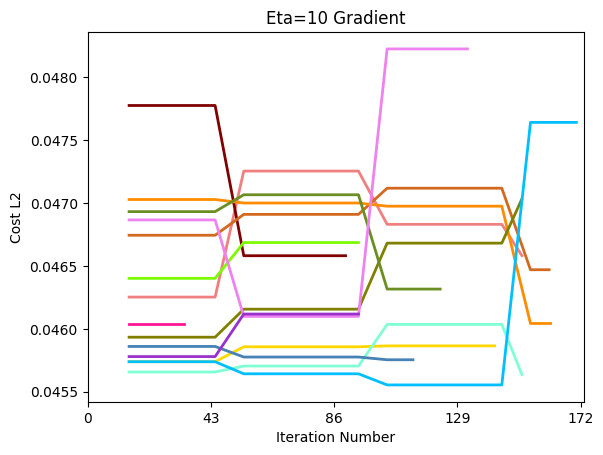

In [5]:
condensed_external_plotting(user_c0_APFL_eta_m10, 'local', plot_gradient=True, local_error=False, 
                            global_error=False, show_update_change=False, custom_title='Eta=10 Gradient')

Safe Learning Rate APFL (Adaptive Off)

In [6]:
user_c0_APFL_slr_15 = [Client(i, D_0_7, 'NAN', cond0_training_and_labels_lst[i], 
                       'streaming', safe_lr=15, adaptive=False, gradient_clipping=True, num_steps=10, 
                       global_method='APFL') for i in range(14)]
global_model_APFL_slr_15 = Server(1, D_0_7, 'APFL', user_c0_APFL_slr_15, num_steps=10)
global_model_APFL_slr_15.execute_FL_loop()

In [7]:
big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_APFL_slr_15.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_APFL_slr_15.all_clients:
    print((my_client.current_round, my_client.current_update))

(Current Local Round, Current Local Update)
(144, 12)
(171, 13)
(162, 13)
(135, 12)
(81, 11)
(163, 13)
(127, 12)
(108, 12)
(108, 12)
(108, 12)
(108, 12)
(144, 12)
(162, 13)
(81, 11)


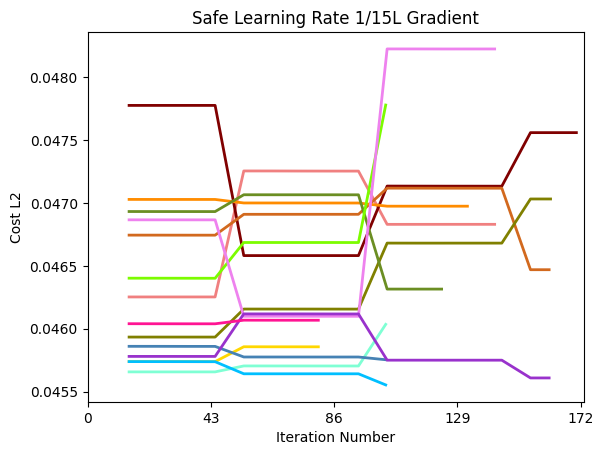

In [8]:
condensed_external_plotting(user_c0_APFL_slr_15, 'local', plot_gradient=True, local_error=False, 
                            global_error=False, show_update_change=False, custom_title='Safe Learning Rate 1/15L Gradient')

Vanilla APFL
> Adaptive is on!

In [9]:
user_c0_APFL = [Client(i, D_0_7, 'NAN', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, gradient_clipping=True, global_method='APFL') for i in range(14)]
global_model_APFL = Server(1, D_0_7, 'APFL', user_c0_APFL, num_steps=10)
global_model_APFL.execute_FL_loop()

In [10]:
big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_APFL.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_APFL.all_clients:
    print((my_client.current_round, my_client.current_update))

(Current Local Round, Current Local Update)
(117, 12)
(99, 11)
(154, 13)
(108, 12)
(117, 12)
(81, 11)
(189, 13)
(99, 11)
(145, 12)
(144, 12)
(171, 13)
(162, 13)
(126, 12)
(90, 11)


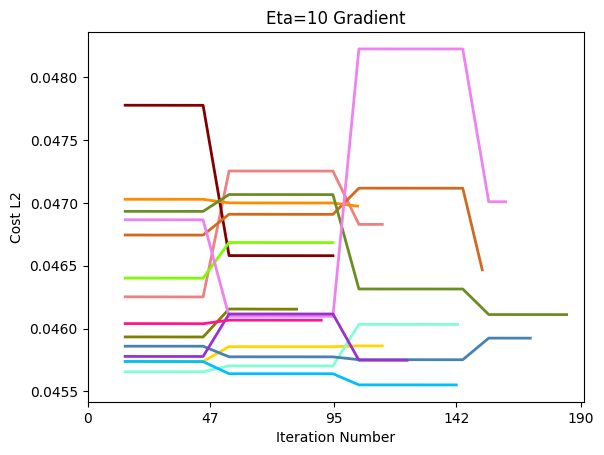

In [11]:
condensed_external_plotting(user_c0_APFL, 'local', plot_gradient=True, local_error=False, 
                            global_error=False, show_update_change=False, custom_title='Eta=10 Gradient')

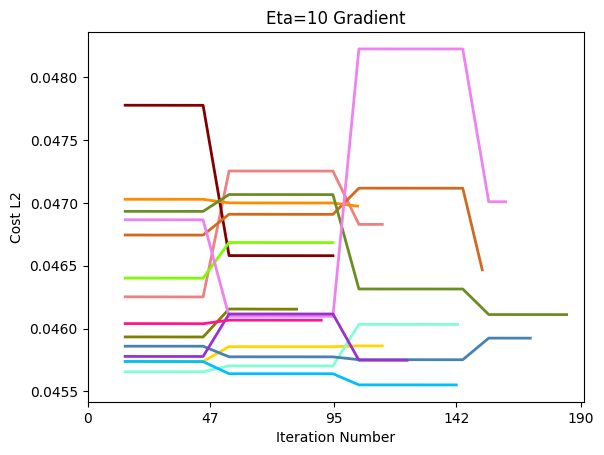

In [12]:
condensed_external_plotting(user_c0_APFL, 'local', plot_gradient=True, local_error=False,
                            global_error=False, show_update_change=False, custom_title='Eta=10 Gradient')

In [13]:
i = global_model_APFL.chosen_clients_lst[0].ID
user_c0_APFL[i].personalized_error_log[-1]#[user_c0_APFL[i].ID]#[2]

0.527

^ Int is not subscriptable!
> Personalized_error_log is not being updated!

In [14]:
eigvals, eigvecs = np.linalg.eig(user_c0_APFL[i].F.T@user_c0_APFL[i].F)
eigvals[:10]

array([1.21047303e+02+0.00000000e+00j, 2.34044834e+01+0.00000000e+00j,
       8.71454215e+00+0.00000000e+00j, 2.72532658e+00+0.00000000e+00j,
       1.13509809e+00+0.00000000e+00j, 6.89516449e-01+0.00000000e+00j,
       5.99955461e-01+0.00000000e+00j, 1.27426060e-15+1.09864231e-14j,
       1.27426060e-15-1.09864231e-14j, 6.96775660e-15+5.08957131e-15j])

In [15]:
mu = np.amin(eigvals)
L = np.amax(eigvals)
print(f"mu: {mu}")
print(f"L: {L.round(3)}")
if mu.real < 1e-10:
    mu = 1e-3
    print(f"New mu: {mu}")
kappa = L/mu
print(f"kappa: {kappa.round(3)}")

# tau is 10 in the above run, for now
a = np.max([128*kappa, 10])  # Max works on an array input, not multiple inputs
eta_t = 16 / (mu*(1+a))
print(f"a: {a.round(3)}")
print(f"eta_t: {eta_t.round(6)}")
print(f"1/2L: {(1/(2*L)).round(6)}")

mu: (-7.476116369784348e-15-3.206898864255108e-15j)
L: (121.047+0j)
New mu: 0.001
kappa: (121047.303+0j)
a: (15494054.84+0j)
eta_t: (0.001033+0j)
1/2L: (0.004131+0j)


In [16]:
lr_limit = 1/(2*L)
print(lr_limit)

(0.0041306165919711615+0j)


In [17]:
safe_lr_limit = 1/(10*L)
print(safe_lr_limit)

(0.0008261233183942322+0j)


In [18]:
eigvals_rounded = eigvals.round(7)

print("10 Eigs")
print(eigvals_rounded[:10])
print("Mu (min eigval)")
print(np.amin(eigvals_rounded))
print("L (max eigval)")
print(np.amax(eigvals_rounded))

10 Eigs
[121.0473034+0.j  23.4044834+0.j   8.7145421+0.j   2.7253266+0.j
   1.1350981+0.j   0.6895164+0.j   0.5999555+0.j   0.       +0.j
   0.       -0.j   0.       +0.j]
Mu (min eigval)
0j
L (max eigval)
(121.0473034+0j)


In [19]:
eigvals_inplace = copy.copy(eigvals)
eps = 1e-7

eigvals_inplace[np.abs(eigvals_inplace) < eps] = 0

print("10 Eigs")
print(eigvals_inplace[:10])
print("Mu (min eigval)")
print(np.amin(eigvals_inplace))
print("L (max eigval)")
print(np.amax(eigvals_inplace))

10 Eigs
[121.04730344+0.j  23.4044834 +0.j   8.71454215+0.j   2.72532658+0.j
   1.13509809+0.j   0.68951645+0.j   0.59995546+0.j   0.        +0.j
   0.        +0.j   0.        +0.j]
Mu (min eigval)
0j
L (max eigval)
(121.04730343936285+0j)


In [20]:
eigvals_ReIm = copy.copy(eigvals)
tol = 1e-7

eigvals_ReIm.real[abs(eigvals_ReIm.real) < tol] = 0.0
eigvals_ReIm.imag[abs(eigvals_ReIm.imag) < tol] = 0.0

print("10 Eigs")
print(eigvals_ReIm[:10])
print("Mu (min eigval)")
print(np.amin(eigvals_ReIm))
print("L (max eigval)")
print(np.amax(eigvals_ReIm))

10 Eigs
[121.04730344+0.j  23.4044834 +0.j   8.71454215+0.j   2.72532658+0.j
   1.13509809+0.j   0.68951645+0.j   0.59995546+0.j   0.        +0.j
   0.        +0.j   0.        +0.j]
Mu (min eigval)
0j
L (max eigval)
(121.04730343936285+0j)


Doing the reverse transposed order, this is supposed to be the same FOR REAL SQUARE MATRICES ONLY.  F is not square though...

In [21]:
eigvals2, eigvecs2 = np.linalg.eig(user_c0_APFL[i].F@user_c0_APFL[i].F.T)
mu2 = np.amin(eigvals2)
L2 = np.amax(eigvals2)

print(f"First 10 eigs: \n {eigvals2[:10]}\n")
print(f"mu2: {mu2}")
print(f"L2: {L2}")

First 10 eigs: 
 [121.04730344  23.4044834    8.71454215   2.72532658   1.13509809
   0.59995546   0.68951645]

mu2: 0.5999554614951723
L2: 121.04730343936285


Misc stuff idk

In [22]:
#i = 0
# This should be the same i as the above loop

print(f"F.shape: {user_c0_APFL[i].F.shape}")
print(f"Norm: {np.linalg.norm(user_c0_APFL[i].F)}")
print(f"Sum: {np.sum((user_c0_APFL[i].F))}")
print(f"**2 Sum: {np.sum((user_c0_APFL[i].F)**2)}")

F.shape: (7, 600)
Norm: 12.582377579816571
Sum: 0.40199497140919505
**2 Sum: 158.3162255610707


In [23]:
hess = user_c0_APFL[i].F@user_c0_APFL[i].F.T
np.linalg.eig(hess)

(array([121.04730344,  23.4044834 ,   8.71454215,   2.72532658,
          1.13509809,   0.59995546,   0.68951645]),
 array([[ 9.99999978e-01,  1.88839702e-04, -7.24465163e-05,
         -2.13154689e-05,  5.32058918e-05, -2.09373952e-05,
          3.27071382e-06],
        [-1.88848244e-04,  9.99999978e-01, -7.84142538e-05,
         -1.72629684e-05,  4.05508961e-05, -1.56524914e-05,
          2.45295427e-06],
        [-7.24354811e-05, -7.84308318e-05, -9.99999992e-01,
         -2.63033150e-05,  5.25783899e-05, -1.94122033e-05,
          3.06402071e-06],
        [ 2.13149283e-05,  1.72684495e-05, -2.63107550e-05,
          9.99999996e-01, -7.76773131e-05,  2.29729617e-05,
         -3.74378801e-06],
        [ 5.31977368e-05,  4.05591934e-05, -5.25879895e-05,
         -7.76859892e-05, -9.99999966e-01,  2.30645511e-04,
         -4.32348075e-05],
        [ 3.26942850e-06,  2.45284428e-06, -3.06372843e-06,
         -3.74257484e-06,  4.32551532e-05,  8.50616926e-05,
         -9.99999995e-01],
  

In [24]:
print("Decs")
print(user_c0_APFL[i].local_w)
print(user_c0_APFL[i].global_w)
diff = user_c0_APFL[i].local_w - user_c0_APFL[i].global_w
print(diff)
print()
print("Gradient")
out = gradient_cost_l2(user_c0_APFL[i].F, user_c0_APFL[i].mixed_w, user_c0_APFL[i].H, user_c0_APFL[i].V, user_c0_APFL[i].learning_batch, user_c0_APFL[i].alphaF, user_c0_APFL[i].alphaD, Ne=7)
print(out.shape)
print(out)

Decs
[[0.34936595 0.49520554 0.73230752 0.23136727 0.96635568 1.
  0.39476816]
 [0.70891663 0.19629626 0.13299752 0.08720805 0.19976123 0.3898065
  0.34064548]]
[[0.34947386 0.49518512 0.73230075 0.23136359 0.9663512  1.
  0.39477232]
 [0.70907273 0.19629687 0.13299891 0.08720924 0.19976351 0.38980667
  0.34064501]]
[[-1.07906337e-04  2.04214237e-05  6.76732146e-06  3.67929275e-06
   4.48014144e-06  0.00000000e+00 -4.15351407e-06]
 [-1.56105923e-04 -6.13015078e-07 -1.38870817e-06 -1.18348983e-06
  -2.27821680e-06 -1.67610311e-07  4.63790189e-07]]

Gradient
(14,)
[0.00903295 0.01156968 0.01692417 0.00532033 0.0221863  0.02295165
 0.0090559  0.01819724 0.0046057  0.00307987 0.00200874 0.00458695
 0.00894541 0.00781597]


In [25]:
np.inner(diff.flatten(), out.flatten())

-3.40105213985654e-06

Look at Vanilla APFL Run

In [26]:
user_c0_APFL[0].adap_alpha[:22]

[0.01,
 0.01001233627732143,
 0.010012335741020902,
 0.010012335280430005,
 0.010012334895551393,
 0.010012334586387719,
 0.010012334352941637,
 0.010012334195215801,
 0.010012334113212866,
 0.010012334106935483,
 0.010154838144315172,
 0.010154838228582675,
 0.010154838388581118,
 0.010154838624313156,
 0.010154838935781445,
 0.010154839322988638,
 0.010154839785937392,
 0.01015484032463036,
 0.0101548409390702,
 0.01029734365650349,
 0.010297344083457583,
 0.010297344586151932]

In [27]:
print(f"F.shape: {user_c0_APFL[0].F.shape}")
print(f"Norm: {np.linalg.norm(user_c0_APFL[0].F)}")
print(f"Sum: {np.sum((user_c0_APFL[0].F))}")
print(f"**2 Sum: {np.sum((user_c0_APFL[0].F)**2)}")

F.shape: (7, 600)
Norm: 14.484250471611098
Sum: -0.7574631422522824
**2 Sum: 209.79351172436628


In [28]:
print(user_c0_APFL[0].local_w)
print(user_c0_APFL[0].global_w)
diff = user_c0_APFL[0].local_w - user_c0_APFL[0].global_w
print(diff)
out = gradient_cost_l2(user_c0_APFL[0].F, user_c0_APFL[0].mixed_w, user_c0_APFL[0].H, user_c0_APFL[0].V, user_c0_APFL[0].learning_batch, user_c0_APFL[0].alphaF, user_c0_APFL[0].alphaD, Ne=7)
print(out.shape)
print(out)

[[0.34940935 0.49518599 0.73231649 0.23136808 0.9663548  1.
  0.394769  ]
 [0.70898676 0.1962953  0.13299932 0.08720854 0.19976102 0.38980626
  0.34064553]]
[[0.34947297 0.49518524 0.73230089 0.23136359 0.96635124 1.
  0.39477227]
 [0.7090728  0.19629676 0.13299896 0.08720921 0.19976349 0.38980667
  0.34064503]]
[[-6.36261684e-05  7.51100514e-07  1.56011542e-05  4.48633793e-06
   3.55704805e-06  0.00000000e+00 -3.26864363e-06]
 [-8.60365083e-05 -1.46097416e-06  3.62231608e-07 -6.77824370e-07
  -2.47483038e-06 -4.17359057e-07  4.97603752e-07]]
(14,)
[0.00920106 0.01186782 0.01688001 0.00532549 0.02223619 0.02298435
 0.0090786  0.01872896 0.00469783 0.00306946 0.00201017 0.00459924
 0.00896057 0.00782323]


In [29]:
np.inner(diff.flatten(), out.flatten())

-1.8695714467279459e-06

Plot

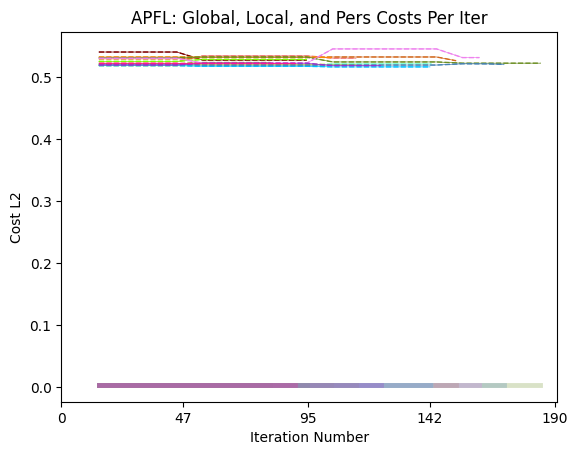

In [30]:
condensed_external_plotting(user_c0_APFL, 'local', pers_error=True, show_update_change=False, custom_title="APFL: Global, Local, and Pers Costs Per Iter")

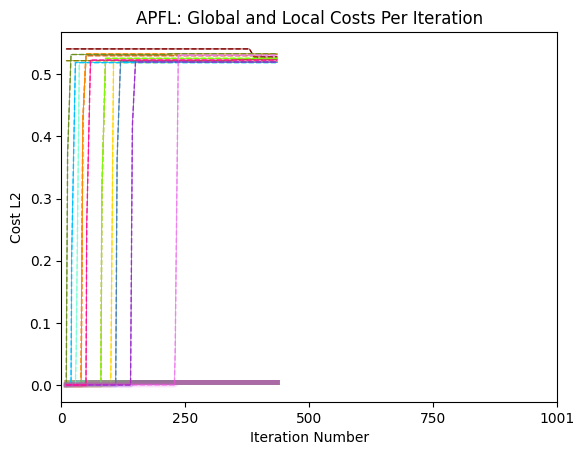

In [31]:
condensed_external_plotting(global_model_APFL, 'global', pers_error=True, show_update_change=False, custom_title="APFL: Global and Local Costs Per Iteration")

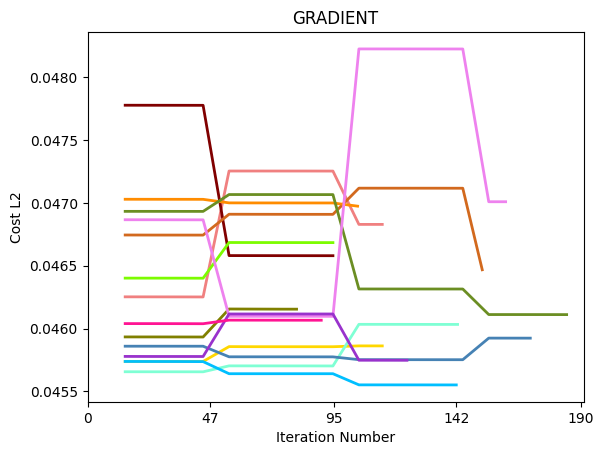

In [32]:
condensed_external_plotting(user_c0_APFL, 'local', plot_gradient=True, local_error=False, global_error=False, show_update_change=False, custom_title='GRADIENT')

In [33]:
global_model_APFL.current_round

1001

In [34]:
#client_loss.append(input_data.global_error_log[j][i][2])
len(global_model_APFL.global_error_log)

2301

In [35]:
len(global_model_APFL.local_error_log)

2301

In [36]:
len(global_model_APFL.personalized_error_log)

2301

In [37]:
assert(1==0)

AssertionError: 

# DEVELOPMENT

# Personalized FL Algorithms
ALL PERSONALIZATION ALGORITHMS
1. APFL
1. Cesar/Taha: AFL + PARS-PUSH
1. PFA: PP F Adaptation for Effective Model Personalization
1. Pers RT FL for Epileptic Seizure Detection
1. An Efficient Framework for Clustered FL
1. Pers FL with DP
## Adaptive Personalized FL Testing Ground

Adapting their code to actually be able to be run in something other than top-down server-only approach
> Their Github: https://github.com/MLOPTPSU/FedTorch <br>
> APFL link: https://github.com/MLOPTPSU/FedTorch/blob/ab8068dbc96804a5c1a8b898fd115175cfebfe75/fedtorch/comms/trainings/federated/apfl.py#L33

loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x. Loss.backward() does not update the weights, only computes the gradients.  The graph is used by loss.backward() to compute gradients.  In pseudo-code: x.grad += dloss/dx

optimizer.step updates the value of x using the gradient x.grad. For example, the SGD optimizer performs:

x += -lr * x.grad
optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.

optimizer.zero_grad() and optimizer.step() do not affect the graph of autograd objects. They only touch the model’s parameters and the parameter’s grad attributes.

If you have multiple losses (loss1, loss2) you can sum them and then call backwards once:

loss3 = loss1 + loss2
loss3.backward()

In [ ]:
#python run_mpi.py -f -ft apfl -n 10 -d mnist -lg 0.1 -b 50 -c 20 -k 1.0 -fs local_step -l 10 -r 2 -pa 0.5 -fp
#'--num_epochs': args.num_epochs_per_comm * args.num_comms,

# num_epochs_per_comm=1
# num_clients=20
# batch_size=50
# num_comms=100
# lr_gamma=1.0
# lr_mu = 1